In [1]:
# Basic imports
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D, BatchNormalization, LSTM, SpatialDropout1D,Bidirectional, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers, optimizers
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

2024-03-26 16:27:05.839490: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-26 16:27:05.839533: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-26 16:27:05.839568: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-26 16:27:05.846712: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train = pd.read_csv(r"../unsw_dataset/UNSW_NB15_training-set.csv")
test = pd.read_csv(r"../unsw_dataset/UNSW_NB15_testing-set.csv")


In [3]:
df = pd.concat([train,test])

In [4]:
df

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.090200,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.000300,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.005100,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.660800,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.002500,...,1,3,0,0,0,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,175337,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,13,24,0,0,0,24,24,0,Generic,1
175337,175338,0.505762,tcp,-,FIN,10,8,620,354,33.612649,...,1,2,0,0,0,1,1,0,Shellcode,1
175338,175339,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,3,13,0,0,0,3,12,0,Generic,1
175339,175340,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,14,30,0,0,0,30,30,0,Generic,1


In [5]:
df.isnull().sum()

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

In [6]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)  

In [7]:
print(df.duplicated().sum(), "fully duplicate rows to remove")

0 fully duplicate rows to remove


In [8]:
train = train.drop(['id'], axis=1)


In [9]:
train

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.000011,udp,-,INT,2,0,496,0,90909.090200,254,...,1,2,0,0,0,1,2,0,Normal,0
1,0.000008,udp,-,INT,2,0,1762,0,125000.000300,254,...,1,2,0,0,0,1,2,0,Normal,0
2,0.000005,udp,-,INT,2,0,1068,0,200000.005100,254,...,1,3,0,0,0,1,3,0,Normal,0
3,0.000006,udp,-,INT,2,0,900,0,166666.660800,254,...,1,3,0,0,0,2,3,0,Normal,0
4,0.000010,udp,-,INT,2,0,2126,0,100000.002500,254,...,1,3,0,0,0,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,0.000005,udp,-,INT,2,0,104,0,200000.005100,254,...,1,2,0,0,0,2,1,0,Normal,0
82328,1.106101,tcp,-,FIN,20,8,18062,354,24.410067,254,...,1,1,0,0,0,3,2,0,Normal,0
82329,0.000000,arp,-,INT,1,0,46,0,0.000000,0,...,1,1,0,0,0,1,1,1,Normal,0
82330,0.000000,arp,-,INT,1,0,46,0,0.000000,0,...,1,1,0,0,0,1,1,1,Normal,0


In [10]:
test = test.drop(['id'], axis=1)


In [11]:
test

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,0,0,0,1,1,0,Normal,0
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,2,0,0,0,1,6,0,Normal,0
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,1,3,0,0,0,2,6,0,Normal,0
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,1,3,1,1,0,2,1,0,Normal,0
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,1,40,0,0,0,2,39,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,...,13,24,0,0,0,24,24,0,Generic,1
175337,0.505762,tcp,-,FIN,10,8,620,354,33.612649,254,...,1,2,0,0,0,1,1,0,Shellcode,1
175338,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,...,3,13,0,0,0,3,12,0,Generic,1
175339,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,...,14,30,0,0,0,30,30,0,Generic,1


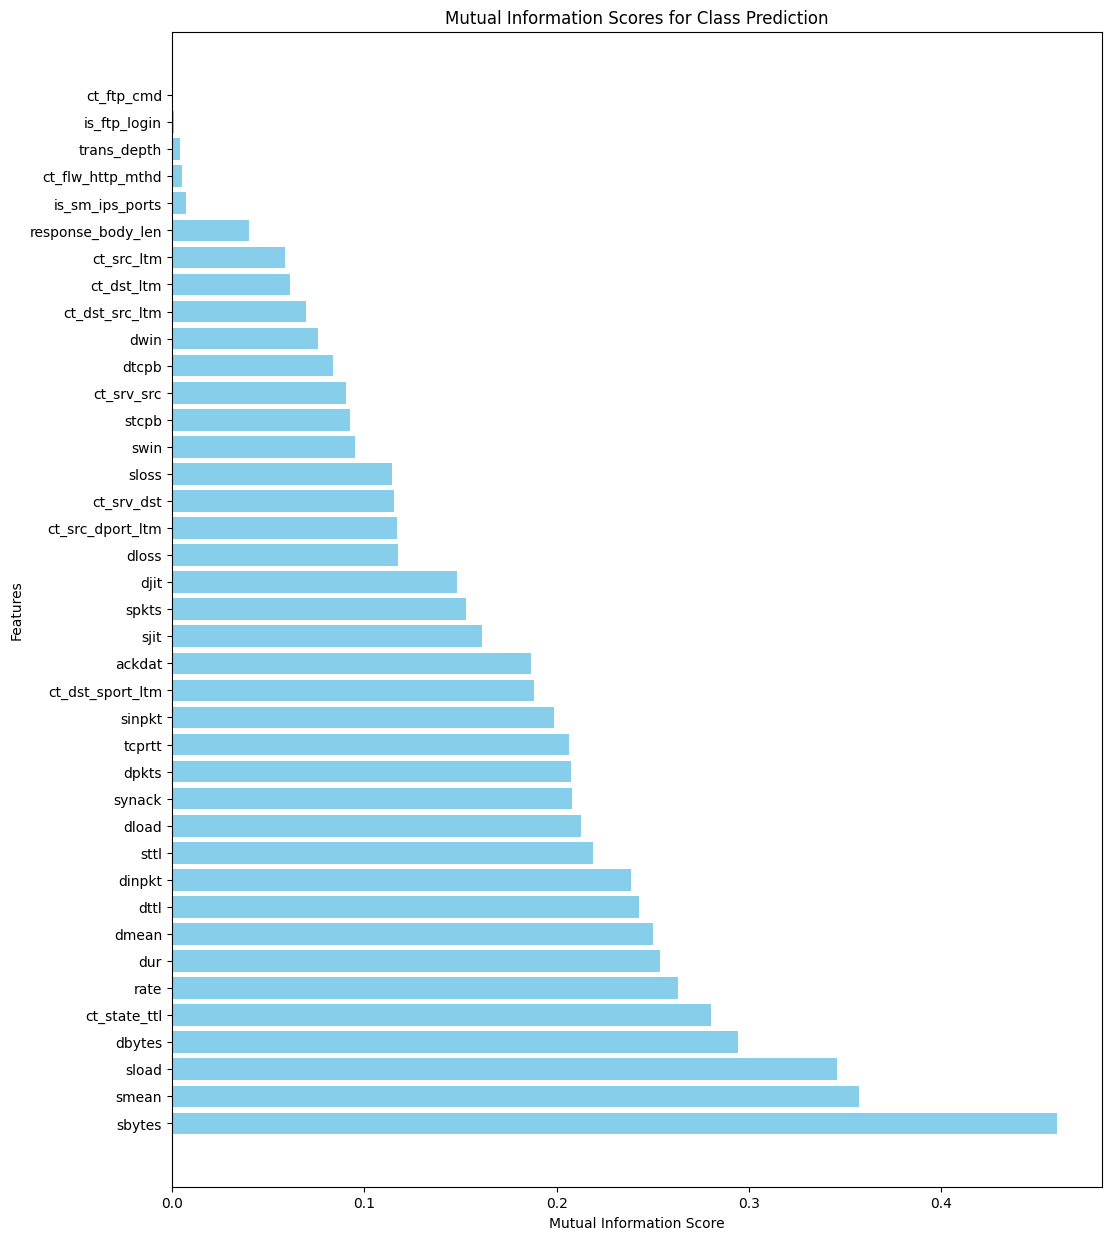

In [12]:
from sklearn.feature_selection import mutual_info_classif

X = train.select_dtypes(include=['int64', 'float64']).drop('label', axis=1)

y = train['label']

mutual_info = mutual_info_classif(X, y, random_state=42)

mi_scores = pd.Series(mutual_info, index=X.columns, name='Mutual Information Score')
mi_scores = mi_scores.sort_values(ascending=False)
plt.figure(figsize=(12, 15))
plt.barh(mi_scores.index, mi_scores, color='skyblue')
plt.title('Mutual Information Scores for Class Prediction')
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.show()

In [13]:
df_encoded = df.copy()

le = LabelEncoder()

df_encoded['attack_cat'] = le.fit_transform(df['attack_cat'])

X = df_encoded.drop('attack_cat', axis=1)
y = df_encoded['attack_cat']

In [15]:
X = df.drop('attack_cat', axis=1)
y = df['attack_cat']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [16]:
print(y_train.value_counts())

attack_cat
Normal            69750
Generic           44153
Exploits          33394
Fuzzers           18184
DoS               12265
Reconnaissance    10490
Analysis           2008
Backdoor           1747
Shellcode          1133
Worms               130
Name: count, dtype: int64


In [14]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
import pandas as pd

In [15]:
# Define the sampling strategies
sampling_strategy_over = {
    "Generic": 50000,
    "Exploits": 45000,
    "Fuzzers": 25000,
    "DoS": 15000,
    "Reconnaissance": 12000,
    "Analysis": 3000,
    "Backdoor": 2000,
    "Shellcode": 2000,
    "Worms": 500
}

sampling_strategy_under = {
    "Normal": 70000
}

over = SMOTE(sampling_strategy=sampling_strategy_over)
under = RandomUnderSampler(sampling_strategy=sampling_strategy_under)

In [16]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# One-hot encode categorical features
categorical_columns = ['proto', 'service', 'state']  # Specify your categorical columns
X = pd.get_dummies(df.drop('attack_cat', axis=1), columns=categorical_columns)
y = df['attack_cat']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the data for Conv1D if necessary
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

encoder = OneHotEncoder(sparse_output=False)
y_train_one_hot = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_one_hot = encoder.transform(y_test.values.reshape(-1, 1))


In [17]:
X_train_res, y_train_res = over.fit_resample(X_train, y_train)
X_train_res, y_train_res = under.fit_resample(X_train_res, y_train_res)

print(y_train_res.value_counts())

attack_cat
Normal            70000
Generic           50000
Exploits          45000
Fuzzers           25000
DoS               15000
Reconnaissance    12000
Analysis           3000
Backdoor           2000
Shellcode          2000
Worms               500
Name: count, dtype: int64


In [18]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights (for scikit-learn version >= 0.22.0)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_res), y=y_train_res)

# Create a mapping from class names to integer indices
class_name_to_index = {class_name: index for index, class_name in enumerate(np.unique(y_train_res))}

# Map class names to integer indices in class weights dictionary
class_weight_dict = {class_name_to_index[class_name]: weight for class_name, weight in zip(np.unique(y_train_res), class_weights)}


In [19]:
# One-hot encode categorical features
categorical_columns = ['proto', 'service', 'state']
df_encoded = pd.get_dummies(df, columns=categorical_columns)

X = df_encoded.drop(['attack_cat'], axis=1)
y = df_encoded['attack_cat']

# Encode the target variable for multi-class classification
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Convert to one-hot encoding
y_encoded_one_hot = to_categorical(y_encoded)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded_one_hot, test_size=0.2, random_state=42)

# Reshape the data for LSTM
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [20]:


# Build the LSTM model for multi-class classification
lstm_with_finetuning = Sequential()
lstm_with_finetuning.add(LSTM(64, activation='tanh',return_sequences=True,input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
lstm_with_finetuning.add(BatchNormalization())

lstm_with_finetuning.add(LSTM(32, activation='tanh', return_sequences=False))  
lstm_with_finetuning.add(Dropout(0.002))  

lstm_with_finetuning.add(Dense(32, activation='relu'))
lstm_with_finetuning.add(Dropout(0.002))

lstm_with_finetuning.add(Dense(units=len(df['attack_cat'].unique()), activation='softmax')) 

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

lstm_with_finetuning.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with callbacks
lstm_with_finetuning.fit(
    X_train_reshaped, y_train,
    epochs=10,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr]
)

2024-03-26 16:30:33.457497: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 72772 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:01:00.0, compute capability: 8.0
2024-03-26 16:30:33.459003: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79065 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:81:00.0, compute capability: 8.0


Epoch 1/10


2024-03-26 16:30:37.282211: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-03-26 16:30:38.186293: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa2f4041220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-26 16:30:38.186321: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-03-26 16:30:38.186329: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-03-26 16:30:38.190091: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-26 16:30:38.259413: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10307/10307 [==============================] - 82s 8ms/step - loss: 0.4519 - accuracy: 0.8366 - val_loss: 0.4023 - val_accuracy: 0.8519 - lr: 0.0010
Epoch 2/10
10307/10307 [==============================] - 78s 8ms/step - loss: 0.3963 - accuracy: 0.8525 - val_loss: 0.3726 - val_accuracy: 0.8612 - lr: 0.0010
Epoch 3/10
10307/10307 [==============================] - 78s 8ms/step - loss: 0.3778 - accuracy: 0.8584 - val_loss: 0.3679 - val_accuracy: 0.8606 - lr: 0.0010
Epoch 4/10
10307/10307 [==============================] - 77s 8ms/step - loss: 0.3704 - accuracy: 0.8604 - val_loss: 0.3641 - val_accuracy: 0.8600 - lr: 0.0010
Epoch 5/10
10307/10307 [==============================] - 77s 8ms/step - loss: 0.3654 - accuracy: 0.8617 - val_loss: 0.3613 - val_accuracy: 0.8630 - lr: 0.0010
Epoch 6/10
10307/10307 [==============================] - 77s 7ms/step - loss: 0.3618 - accuracy: 0.8624 - val_loss: 0.3516 - val_accuracy: 0.8668 - lr: 0.0010
Epoch 7/10
10307/10307 [===========================

In [21]:
test_loss, test_accuracy = lstm_with_finetuning.evaluate(X_test_reshaped, y_test)

print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test Loss: {:.2f}%".format(test_loss * 100))

1611/1611 [==============================] - 5s 3ms/step - loss: 0.3367 - accuracy: 0.8693
Test Accuracy: 86.93%
Test Loss: 33.67%


In [22]:
y_pred = lstm_with_finetuning.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)

y_test_original = label_encoder.inverse_transform(y_test.argmax(axis=1))
y_pred_original = label_encoder.inverse_transform(y_pred_classes)

class_names = np.unique(y_test_original)

# Classification report
report = classification_report(y_test_original, y_pred_original, target_names=class_names)
print(report)

1611/1611 [==============================] - 5s 3ms/step
                precision    recall  f1-score   support

      Analysis       0.66      0.20      0.31       538
      Backdoor       0.46      0.01      0.02       471
           DoS       0.40      0.23      0.30      3293
      Exploits       0.65      0.84      0.73      8853
       Fuzzers       0.83      0.86      0.84      4742
       Generic       1.00      0.98      0.99     11849
        Normal       1.00      1.00      1.00     18675
Reconnaissance       0.81      0.74      0.77      2770
     Shellcode       0.69      0.36      0.48       318
         Worms       0.47      0.27      0.34        26

      accuracy                           0.87     51535
     macro avg       0.70      0.55      0.58     51535
  weighted avg       0.86      0.87      0.86     51535



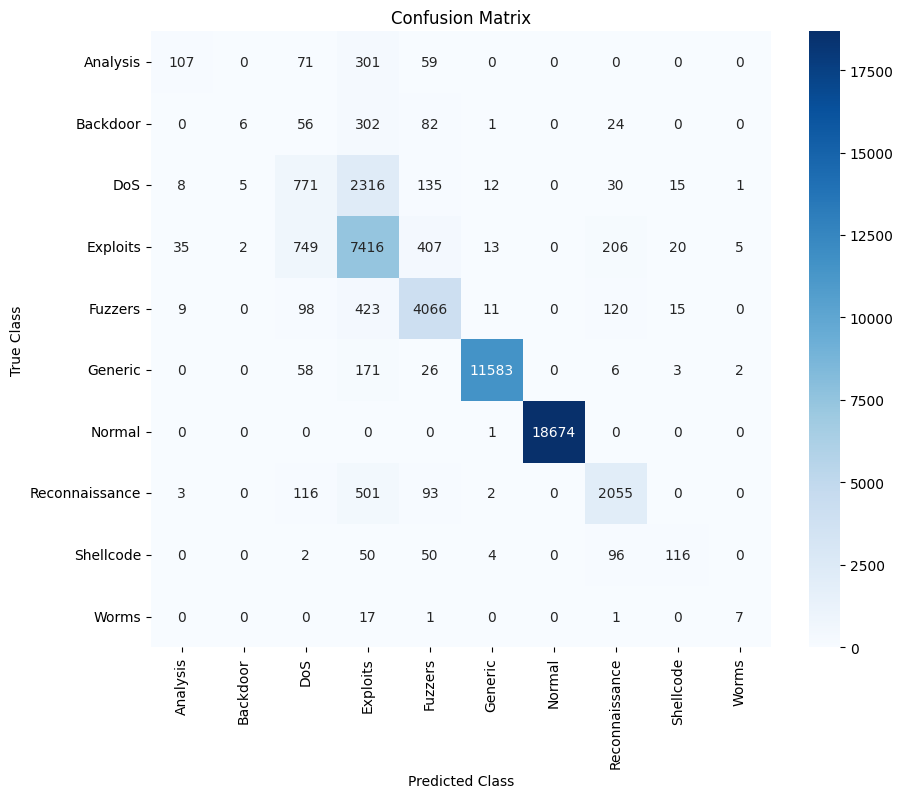

In [23]:
y_true_indices = np.argmax(y_test, axis=1)
y_pred_indices = np.argmax(y_pred, axis=1)

class_names = np.unique(y_test_original)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_indices, y_pred_indices)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(y_test_original, y_pred_original, average='weighted')
recall = recall_score(y_test_original, y_pred_original, average='weighted')
f1 = f1_score(y_test_original, y_pred_original, average='weighted')
accuracy = accuracy_score(y_test_original, y_pred_original)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Accuracy: {accuracy}')


Precision: 0.8630448190195686
Recall: 0.8693315222664209
F1 Score: 0.858954621716328
Accuracy: 0.8693315222664209


In [25]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  

# Reshape input to be 3D [samples, timesteps, features] for LSTM
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

num_classes = y_train.shape[1]  

model = Sequential()
model.add(LSTM(40, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dropout(0.002))
model.add(LSTM(40, return_sequences=True))
model.add(Dropout(0.002))
model.add(LSTM(40, return_sequences=True))
model.add(Dropout(0.002))
model.add(LSTM(40))
model.add(Dropout(0.002))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.002)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model with callbacks
history = model.fit(
    X_train_reshaped, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_reshaped, y_test),
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/10
6442/6442 [==============================] - 65s 10ms/step - loss: 0.4535 - accuracy: 0.8373 - val_loss: 0.4030 - val_accuracy: 0.8509 - lr: 0.0020
Epoch 2/10
6442/6442 [==============================] - 61s 10ms/step - loss: 0.3777 - accuracy: 0.8596 - val_loss: 0.3765 - val_accuracy: 0.8594 - lr: 0.0020
Epoch 3/10
6442/6442 [==============================] - 61s 9ms/step - loss: 0.3629 - accuracy: 0.8632 - val_loss: 0.3491 - val_accuracy: 0.8675 - lr: 0.0020
Epoch 4/10
6442/6442 [==============================] - 61s 9ms/step - loss: 0.3526 - accuracy: 0.8657 - val_loss: 0.3407 - val_accuracy: 0.8705 - lr: 0.0020
Epoch 5/10
6442/6442 [==============================] - 61s 9ms/step - loss: 0.3462 - accuracy: 0.8677 - val_loss: 0.3385 - val_accuracy: 0.8701 - lr: 0.0020
Epoch 6/10
6442/6442 [==============================] - 62s 10ms/step - loss: 0.3410 - accuracy: 0.8689 - val_loss: 0.3340 - val_accuracy: 0.8711 - lr: 0.0020
Epoch 7/10
6442/6442 [===========================

In [26]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test)

print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test Loss: {:.2f}%".format(test_loss * 100))

1611/1611 [==============================] - 7s 4ms/step - loss: 0.3250 - accuracy: 0.8740
Test Accuracy: 87.40%
Test Loss: 32.50%


In [27]:
y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)

y_test_original = label_encoder.inverse_transform(y_test.argmax(axis=1))
y_pred_original = label_encoder.inverse_transform(y_pred_classes)

class_names = np.unique(y_test_original)

# Classification report
report = classification_report(y_test_original, y_pred_original, target_names=class_names)
print(report)

1611/1611 [==============================] - 6s 3ms/step
                precision    recall  f1-score   support

      Analysis       0.71      0.19      0.30       538
      Backdoor       0.42      0.07      0.12       471
           DoS       0.52      0.07      0.12      3293
      Exploits       0.61      0.94      0.74      8853
       Fuzzers       0.88      0.84      0.86      4742
       Generic       1.00      0.98      0.99     11849
        Normal       1.00      1.00      1.00     18675
Reconnaissance       0.89      0.70      0.78      2770
     Shellcode       0.64      0.53      0.58       318
         Worms       0.80      0.15      0.26        26

      accuracy                           0.87     51535
     macro avg       0.75      0.55      0.57     51535
  weighted avg       0.87      0.87      0.85     51535



In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(y_test_original, y_pred_original, average='weighted')
recall = recall_score(y_test_original, y_pred_original, average='weighted')
f1 = f1_score(y_test_original, y_pred_original, average='weighted')
accuracy = accuracy_score(y_test_original, y_pred_original)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Accuracy: {accuracy}')


Precision: 0.8746660792092505
Recall: 0.8739691471815271
F1 Score: 0.8534206054129327
Accuracy: 0.8739691471815271


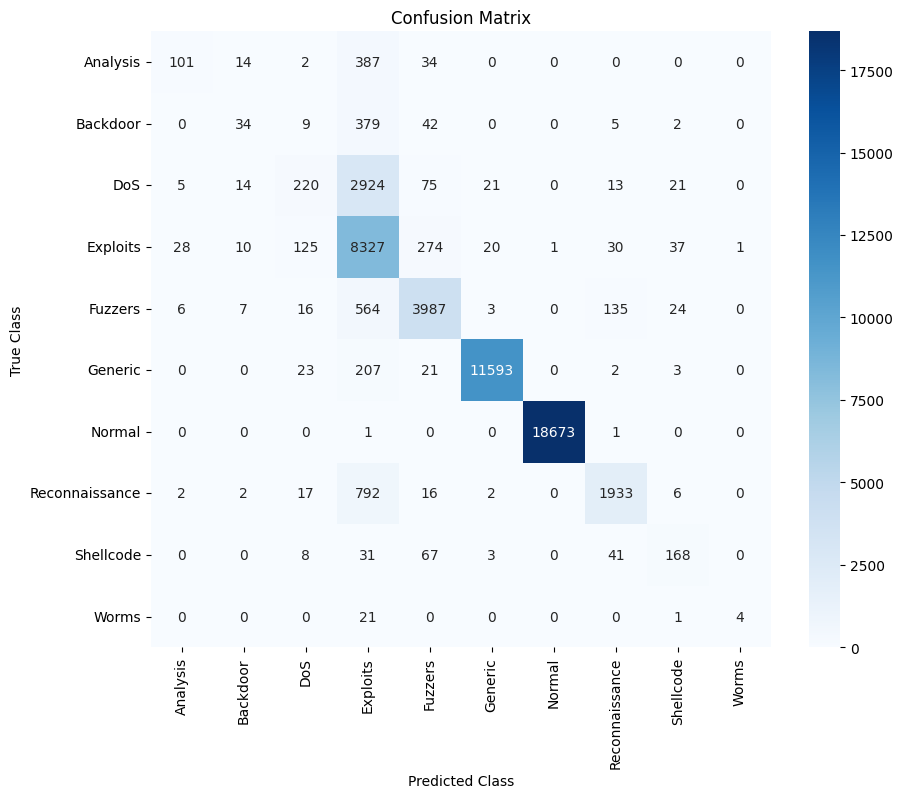

In [29]:
y_true_indices = np.argmax(y_test, axis=1)
y_pred_indices = np.argmax(y_pred, axis=1)

class_names = np.unique(y_test_original)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_indices, y_pred_indices)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()